# Calculating Climate Anomaly

## Introduction

A climate anomaly refers to the difference between a measured climate variable and its long-term average or climatology. XArray provides many built-in methods to aggregate and compute statistical averages. In this tutorial, we explore these methods to calculate and visualize soil moisture anomalies.

## Overview of the Task

We will take [monthly gridded soil moisture](https://psl.noaa.gov/data/gridded/data.cpcsoil.html) data from NOAA Climate Prediction Center and calculate monthly anomalies relative to the 1971-2000 climatology.

**Input Layers**:
* `soilw.mon.mean.v2.nc`: A NetCDF file containing monthly mean soil moisture data from 1948 to current.

**Output**:
* Plots of monthly soil moisture anomalies for each month of 2024.

**Data Credit**:
*   [Global Soil Moisture](https://psl.noaa.gov/thredds/catalog/Datasets/cpcsoil/catalog.html). NOAA Climate Prediction Center. Retrieved 2025-02


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [7]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install cartopy

In [41]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr

In [9]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

## Data Pre-Processing

XArray can directly fetch data from a remote server. We specify the file path to the remote NetCDF file and open it.

In [15]:
filename = 'soilw.mon.mean.v2.nc'
server_url = 'https://psl.noaa.gov/thredds/fileServer/Datasets/cpcsoil/'
data_url = server_url + filename
ds = xr.open_dataset(data_url)
ds

<xarray.Dataset> Size: 959MB
Dimensions:  (lat: 360, lon: 720, time: 925)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-01-01
Data variables:
    soilw    (time, lat, lon) float32 959MB ...
Attributes:
    Conventions:    CF-1.0
    title:          CPC Soil Moisture
    institution:    NOAA/ESRL PSD
    dataset_title:  CPC Soil Moisture
    history:        Wed Oct 18 15:13:37 2017: ncks -d time,,-2 soilw.mon.mean...
    NCO:            4.6.9
    References:     https://www.psl.noaa.gov/data/gridded/data.cpcsoil.html
    source:         https://www.cpc.ncep.noaa.gov/products/Soilmst_Monitoring...

Select the `soilw` variable.

In [16]:
da = ds['soilw']
da

<xarray.DataArray 'soilw' (time: 925, lat: 360, lon: 720)> Size: 959MB
[239760000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-01-01
Attributes:
    long_name:      Model-Calculated Monthly Mean Soil Moisture
    units:          mm
    valid_range:    [   0. 1000.]
    dataset:        CPC Monthly Soil Moisture
    var_desc:       Soil Moisture
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Other
    standard_name:  lwe_thickness_of_soil_moisture_content
    cell_methods:   time: mean (monthly from values)
    actual_range:   [  0.     756.0375]

We transform the data from 0-360 longitude to -180 - +180 longitudes.

In [17]:
da.coords['lon'] = (da.coords['lon'] + 180) % 360 - 180
da = da.sortby(da.lon)

## Calculating Anomaly

Let's calculate soil moisture anomaly for 2021 as defined as the departure relative to the 1971–2000 climatology. We group the data by months and calculate monthly means across the entire time perid. We get a DataArray of 12 monthly means. Subtract the mean monthly soil moisture from each month to get the monthly anomalies.

In [ ]:
%%time
mean = da.sel(time=slice('1971', '2000')).groupby('time.month').mean('time')
anomaly = da.groupby('time.month') - mean

We now plot the monthly anomaly for each month of 2024.

In [48]:
anomaly2024 = anomaly.sel(time='2024')

We create a layout with 12 subplots (6 rows and 2 columns). The result will be a 2D NumPy array of Axes for each subplot. To easily iterate over each, use use NumPy's `numpy.ndarray.flat` attribute to get a flattened 1D array. The `enumerate()` function will give us the index of the array along with the Axes object from the array.

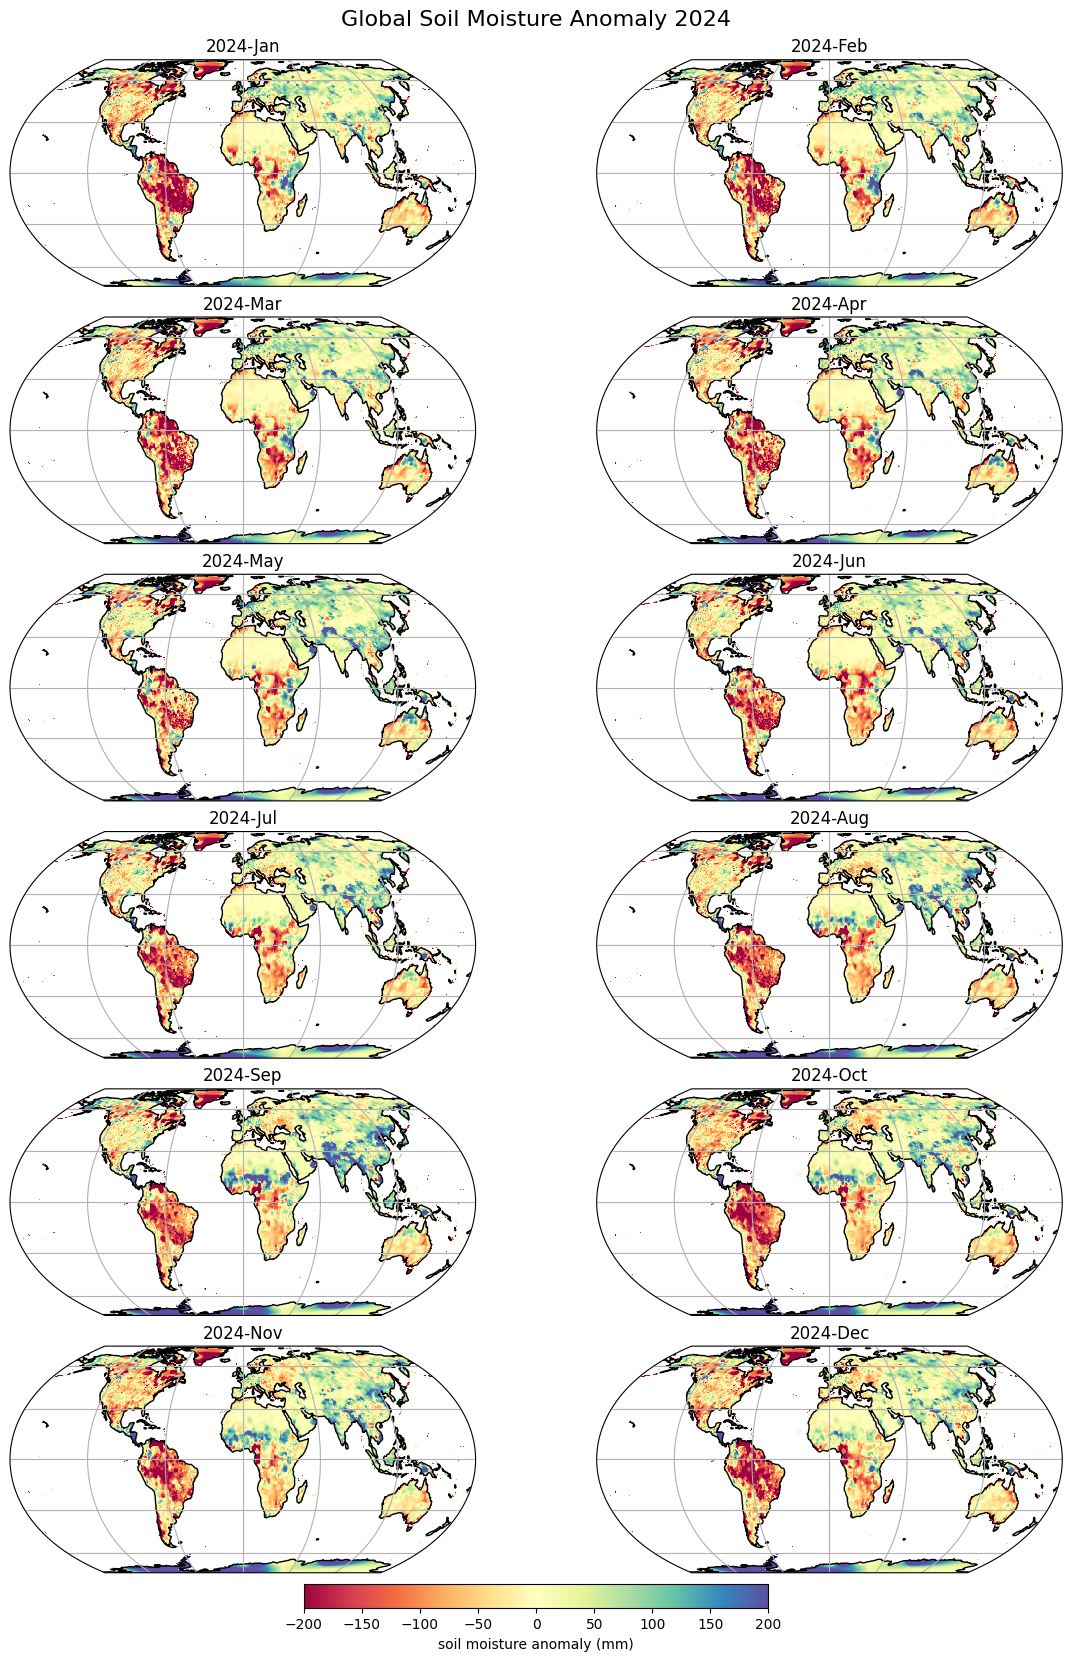

In [51]:
projection = ccrs.EqualEarth()

fig, axes = plt.subplots(6, 2, sharex=True, sharey=True,
                         constrained_layout=True,
                         subplot_kw={'projection': projection})
fig.set_size_inches(11.7, 16.5)


for index, ax in enumerate(axes.flat):
    data = anomaly2024.isel(time=index)
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),  # Data is in PlateCarree
        cmap='Spectral',
        vmin=-200, vmax=200,
        add_colorbar=False, add_labels=False)
    title = pd.to_datetime(data.time.values).strftime('%Y-%b')
    ax.set_title(title)
    ax.set_aspect('equal')
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()

# Place the colorbar spanning the two bottom axes
fig.colorbar(im, ax=axes[5, :2], shrink=0.4, pad=0.05, location='bottom',
             label='soil moisture anomaly (mm)')
fig.suptitle('Global Soil Moisture Anomaly 2024', fontsize=16)
plt.show()

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>